# Lec 11. Simple CNN : 한글 자모

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as Data

import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Load Custom Data

* transforms에 대해서는 다음 참조

https://pytorch.org/docs/stable/torchvision/transforms.html

In [3]:
img_dir = "data/hangul/"
img_data = dsets.ImageFolder(img_dir, 
                             transforms.Compose([
                                 transforms.Grayscale(),
                                 
#                                  # Data Augmentation
#                                  transforms.RandomRotation(15)
#                                  transforms.CenterCrop(28),
#                                  transforms.Lambda(lambda x: x.rotate(15)),
                                 
#                                  # Data Nomalization
#                                  transforms.Normalize(mean=(0.5,), std=(0.5,))

                                 transforms.ToTensor(),
                             ]))

print(img_data.classes)
print(img_data.class_to_idx)  # class 39 - 각 class별 720개 이미지 존재.

['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', 'ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
{'ㄱ': 0, 'ㄲ': 1, 'ㄴ': 2, 'ㄷ': 3, 'ㄸ': 4, 'ㄹ': 5, 'ㅁ': 6, 'ㅂ': 7, 'ㅃ': 8, 'ㅅ': 9, 'ㅆ': 10, 'ㅇ': 11, 'ㅈ': 12, 'ㅉ': 13, 'ㅊ': 14, 'ㅋ': 15, 'ㅌ': 16, 'ㅍ': 17, 'ㅎ': 18, 'ㅏ': 19, 'ㅐ': 20, 'ㅑ': 21, 'ㅒ': 22, 'ㅓ': 23, 'ㅔ': 24, 'ㅕ': 25, 'ㅖ': 26, 'ㅗ': 27, 'ㅘ': 28, 'ㅙ': 29, 'ㅛ': 30, 'ㅜ': 31, 'ㅝ': 32, 'ㅞ': 33, 'ㅟ': 34, 'ㅠ': 35, 'ㅡ': 36, 'ㅢ': 37, 'ㅣ': 38}


In [4]:
len(img_data) # = 39 * 720

28080

In [5]:
img_data.imgs[0]

('data/hangul/ㄱ\\001.png', 0)

(36, 36)


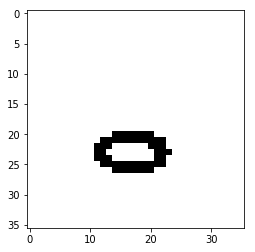

In [6]:
img = Image.open("data/hangul/ㅇ/111.png").convert("L")   # 36 * 36 image
imgarr = np.array(img)
print(imgarr.shape)
plt.imshow(imgarr, cmap='gray')

In [7]:
batch_size = 100
font_num = 720

In [8]:
from torch.utils.data import Sampler

In [9]:
def train_test_split(data, train_ratio, stratify, stratify_num, batch_size) :
    
    length = len(data)
    
    # 층화 추출
    if stratify :
        label_num = int(len(data)/stratify_num)
        cut = int(stratify_num*train_ratio)
        train_indices = np.random.permutation(np.arange(stratify_num))[:cut]
        test_indices = np.random.permutation(np.arange(stratify_num))[cut:]
        
        for i in range(1, label_num) :
            train_indices = np.concatenate((train_indices, np.random.permutation(np.arange(stratify_num))[:cut] + stratify_num*i))
            test_indices = np.concatenate((test_indices, np.random.permutation(np.arange(stratify_num))[cut:] + stratify_num*i))
        
    else :
        cut = int(len(data)*train_ratio)
        train_indices = np.random.permutation(np.arange(length))[:cut]
        test_indices = np.random.permutation(np.arange(length))[cut:]
        
    sampler = Data.SubsetRandomSampler(train_indices)
    
    train_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler=sampler, num_workers=0, drop_last=True)
    test_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler=sampler, num_workers=0, drop_last=True)

    return train_loader, test_loader, len(train_indices), len(test_indices)

In [10]:
train_loader, test_loader, train_num, test_num = train_test_split(img_data, 0.8, True, font_num, batch_size)

In [11]:
train_num, test_num

(22464, 5616)

## Define Model

In [12]:
def c_conv(N, K, P=0, S=1):
    return int((N + 2*P - K) / S + 1)

def c_pool(N, K):
    return int(N/K)

In [13]:
c0 = 36
c1 = c_conv(c0, 3)
c2 = c_conv(c1, 3)
c3 = c_pool(c2, 2)

c4 = c_conv(c3, 3)
c5 = c_conv(c4, 3)
c6 = c_pool(c5, 2)

print(c1, c2, c3, c4, c5, c6)

34 32 16 14 12 6


In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Test 1 - 84.78 %
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3),    # 36 --> 34
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16,32,3),   # 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),    # 16

            nn.Conv2d(32,64,3),   # 14
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,128,3),   # 12
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)      # 6
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(128*6*6,300),
            nn.ReLU(),
            nn.Linear(300,39)
        )
        
        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # init.xavier_normal(m.weight.data)
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)

        return out
    
model = CNN().cuda()

In [15]:
loss = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Adam
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Momentum & Weight Regularization(L2)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5)

In [16]:
num_epochs = 10

In [17]:
# Learning Rate Scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma= 0.99)
# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10,30,80], gamma= 0.1)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [18]:
total_batch = train_num//batch_size

for epoch in range(num_epochs):
    
#     scheduler.step()

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pred = model(X)
        cost = loss(pred, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.5f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [224/224] Loss: 0.28873
Epoch [2/10], lter [224/224] Loss: 0.13322
Epoch [3/10], lter [224/224] Loss: 0.05497
Epoch [4/10], lter [224/224] Loss: 0.02143
Epoch [5/10], lter [224/224] Loss: 0.02459
Epoch [6/10], lter [224/224] Loss: 0.03388
Epoch [7/10], lter [224/224] Loss: 0.01384
Epoch [8/10], lter [224/224] Loss: 0.01262
Epoch [9/10], lter [224/224] Loss: 0.00434
Epoch [10/10], lter [224/224] Loss: 0.01707


In [19]:
# torch.save(model.state_dict(), 'cnn_hangul_Adam.pkl')
# print("Model Saved!")

## Test Model

In [20]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
#     print(outputs.data)   # 39 class에 대한 확률
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
    
correct = correct.cpu().numpy()    
print('correct :', correct)
print('total   :', total)
print('Accuracy of test images: %f' % (100 * correct / total))

correct : 22398
total   : 22400
Accuracy of test images: 99.991071
